<a href="https://colab.research.google.com/github/Harsha1115/ML-disaster-tweets/blob/main/Term_Project_Harsha_Update1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# 1) Basic setup
!python -V
!pip -q install pandas numpy scikit-learn matplotlib torch torchvision torchaudio transformers datasets tqdm

# 2) Clean repo-like folders
import os, json, textwrap, pathlib
base = "/content/ml-m1-disaster-tweets"
dirs = [
    "data/raw", "data/processed",
    "notebooks", "src", "scripts",
    "outputs/figs", "outputs/metrics", "outputs/checkpoints",
    "report/screenshots"
]
for d in dirs:
    os.makedirs(f"{base}/{d}", exist_ok=True)
print("Created:", *dirs, sep="\n - ")


Python 3.12.12
Created:
 - data/raw
 - data/processed
 - notebooks
 - src
 - scripts
 - outputs/figs
 - outputs/metrics
 - outputs/checkpoints
 - report/screenshots


In [55]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [56]:
!kaggle competitions download -c nlp-getting-started -p /content/
!unzip -o /content/nlp-getting-started.zip -d /content/


nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/nlp-getting-started.zip
  inflating: /content/sample_submission.csv  
  inflating: /content/test.csv       
  inflating: /content/train.csv      


In [57]:
import os, shutil
base = "/content/ml-m1-disaster-tweets"
os.makedirs(f"{base}/data/raw", exist_ok=True)
for f in ["train.csv","test.csv","sample_submission.csv"]:
    shutil.move(f"/content/{f}", f"{base}/data/raw/{f}")
!ls -lh {base}/data/raw


total 1.4M
-rw-r--r-- 1 root root  23K Dec 16  2019 sample_submission.csv
-rw-r--r-- 1 root root 411K Dec 16  2019 test.csv
-rw-r--r-- 1 root root 965K Dec 16  2019 train.csv


In [58]:
import pandas as pd, matplotlib.pyplot as plt
base = "/content/ml-m1-disaster-tweets"

df = pd.read_csv(f"{base}/data/raw/train.csv")
print("Shape:", df.shape)
df.head(5)


Shape: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [59]:
print(df.isna().sum())    # check missing values first

df['keyword'] = df['keyword'].fillna('')
df['location'] = df['location'].fillna('')

print("✅ NaN values handled — ready for visualization")


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
✅ NaN values handled — ready for visualization


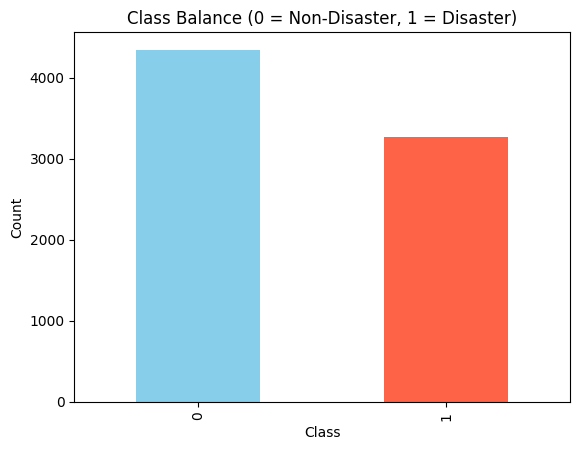

In [60]:
import matplotlib.pyplot as plt
ax = df['target'].value_counts().plot(
    kind='bar',
    title='Class Balance (0 = Non-Disaster, 1 = Disaster)',
    color=['skyblue', 'tomato']
)
plt.xlabel("Class"); plt.ylabel("Count")
plt.show()


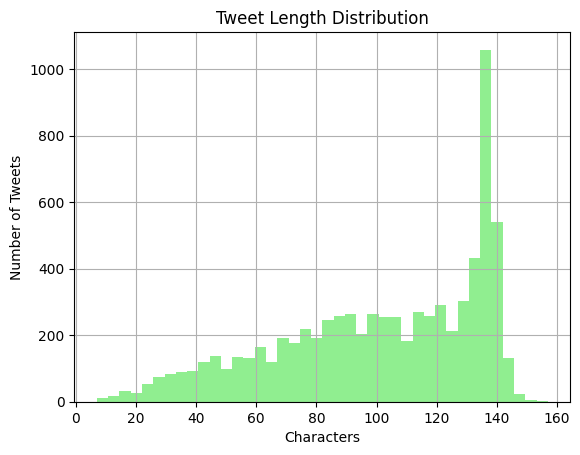

In [61]:
df['len'] = df['text'].str.len()
df['len'].hist(bins=40, color='lightgreen')
plt.title("Tweet Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Number of Tweets")
plt.show()


In [62]:
base = "/content/ml-m1-disaster-tweets"

# Save class balance plot
plt.figure()
df['target'].value_counts().plot(kind='bar', color=['skyblue','tomato'])
plt.title("Class Balance")
plt.savefig(f"{base}/outputs/figs/class_balance.png", dpi=200)
plt.close()

# Save tweet length plot
plt.figure()
df['len'].hist(bins=40, color='lightgreen')
plt.title("Tweet Length Distribution")
plt.xlabel("Characters"); plt.ylabel("Count")
plt.savefig(f"{base}/outputs/figs/tweet_length.png", dpi=200)
plt.close()

print("📁 Saved EDA plots under:", f"{base}/outputs/figs/")


📁 Saved EDA plots under: /content/ml-m1-disaster-tweets/outputs/figs/


In [63]:
import glob
base = "/content/ml-m1-disaster-tweets"
print("EDA Figures:", glob.glob(f"{base}/outputs/figs/*"))


EDA Figures: ['/content/ml-m1-disaster-tweets/outputs/figs/class_balance.png', '/content/ml-m1-disaster-tweets/outputs/figs/baseline_cm.png', '/content/ml-m1-disaster-tweets/outputs/figs/loss_curve_distilbert.png', '/content/ml-m1-disaster-tweets/outputs/figs/tweet_length.png']


✅ Baseline Model — Accuracy: 0.8070, F1-score: 0.7637


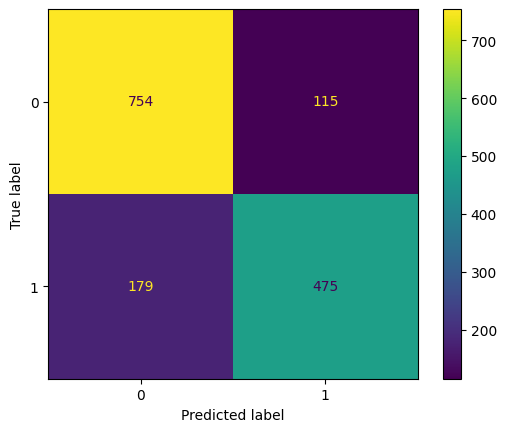

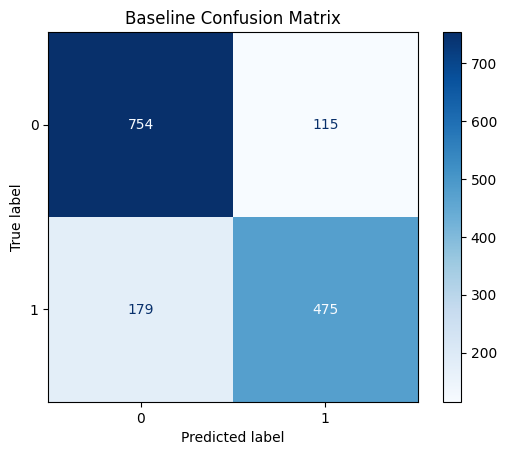

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
import pandas as pd, matplotlib.pyplot as plt, os

base = "/content/ml-m1-disaster-tweets"
df = pd.read_csv(f"{base}/data/raw/train.csv")

# Split data (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    df['text'], df['target'],
    test_size=0.2, random_state=42, stratify=df['target']
)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
Xtr = tfidf.fit_transform(X_train)
Xv = tfidf.transform(X_val)

# Logistic Regression
clf = LogisticRegression(max_iter=2000, n_jobs=-1)
clf.fit(Xtr, y_train)
pred = clf.predict(Xv)

# Evaluate
acc = accuracy_score(y_val, pred)
f1 = f1_score(y_val, pred)
print(f"✅ Baseline Model — Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

# Save metrics + confusion matrix
os.makedirs(f"{base}/outputs/metrics", exist_ok=True)
pd.DataFrame([{"accuracy": acc, "f1": f1}]).to_csv(f"{base}/outputs/metrics/baseline.csv", index=False)

disp = ConfusionMatrixDisplay.from_predictions(y_val, pred)
disp.plot(cmap='Blues')
plt.title("Baseline Confusion Matrix")
plt.savefig(f"{base}/outputs/figs/baseline_cm.png", dpi=200)
plt.show()


In [65]:
import glob
base = "/content/ml-m1-disaster-tweets"
print("Metrics:", glob.glob(f"{base}/outputs/metrics/*"))
print("Figures:", glob.glob(f"{base}/outputs/figs/*"))


Metrics: ['/content/ml-m1-disaster-tweets/outputs/metrics/distilbert.csv', '/content/ml-m1-disaster-tweets/outputs/metrics/baseline.csv']
Figures: ['/content/ml-m1-disaster-tweets/outputs/figs/class_balance.png', '/content/ml-m1-disaster-tweets/outputs/figs/baseline_cm.png', '/content/ml-m1-disaster-tweets/outputs/figs/loss_curve_distilbert.png', '/content/ml-m1-disaster-tweets/outputs/figs/tweet_length.png']


In [66]:
!pip -q install -U "transformers>=4.40" "datasets>=2.19" "accelerate>=0.30" "evaluate"
import transformers, datasets, accelerate
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("accelerate:", accelerate.__version__)


transformers: 4.57.1
datasets: 4.0.0
accelerate: 1.11.0


In [67]:
import os, pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score

base = "/content/ml-m1-disaster-tweets"

# 1) Data split with sklearn (stratified)
df = pd.read_csv(f"{base}/data/raw/train.csv").rename(columns={'text':'sentence','target':'label'})
df['label'] = df['label'].astype(int)
train_df, test_df = train_test_split(df[['sentence','label']], test_size=0.2,
                                     random_state=42, stratify=df['label'])
ds_train = Dataset.from_pandas(train_df.reset_index(drop=True))
ds_test  = Dataset.from_pandas(test_df.reset_index(drop=True))

# 2) Tokenize
tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def tokenize(b):
    return tok(b['sentence'], truncation=True, padding='max_length', max_length=128)
ds_train = ds_train.map(tokenize, batched=True)
ds_test  = ds_test.map(tokenize, batched=True)

# 3) Model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# 4) Training args (no evaluation_strategy key)
args = TrainingArguments(
    output_dir=f"{base}/outputs/checkpoints",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    logging_steps=50,
    save_strategy="epoch",
    do_eval=True,              # we’ll call trainer.evaluate() explicitly
    report_to="none",
)

def metrics_fn(p):
    import numpy as np
    from sklearn.metrics import accuracy_score, f1_score
    preds = p.predictions.argmax(-1)
    return {"acc": accuracy_score(p.label_ids, preds), "f1": f1_score(p.label_ids, preds)}

trainer = Trainer(model=model, args=args,
                  train_dataset=ds_train, eval_dataset=ds_test,
                  tokenizer=tok, compute_metrics=metrics_fn)

trainer.train()
final_metrics = trainer.evaluate()
print("✅ DistilBERT eval:", final_metrics)

#create metrics folder and save
os.makedirs(f"{base}/outputs/metrics", exist_ok=True)
pd.DataFrame([final_metrics]).to_csv(f"{base}/outputs/metrics/distilbert.csv", index=False)

trainer.save_model(f"{base}/outputs/checkpoints/distilbert_best")


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1825593198.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args,


Step,Training Loss
50,0.528200
100,0.490900
150,0.441200
200,0.415400
250,0.439000
300,0.413900
350,0.451300
400,0.332500
450,0.313400
500,0.301800


✅ DistilBERT eval: {'eval_loss': 0.4063073992729187, 'eval_acc': 0.8417596848325674, 'eval_f1': 0.8100866824271079, 'eval_runtime': 4.9702, 'eval_samples_per_second': 306.425, 'eval_steps_per_second': 9.658, 'epoch': 2.0}
